# Deloitte's Quantum Climate Challenge 2023

The challenge focuses on CO2 captuere in MOFs (Metal Organic Frameworks) ans is dvided in two principal tasks

## Task 1: Calculate the minimum of the potential energy surface of combinations gas molecules and metallic ions

### Task 1A: Build a quantum/quantum-hybrid algorithm. Run simulations and on real quantum devices

Pick at least one metallic ion from the list:
* __Mg2+ (2p6 - 10 e-)__
* Mn2+ (3d5 - 23 e-)
* Fe2+ (3d6 - 24 e-)
* Co2+ (3d7 - 25 e-)
* Ni2+ (3d8 - 26 e-)
* Cu2+ (3d9 - 27 e-)
* __Zn2+ (3d10 - 28 e-)__

And study the composite system with CO2 and another gas molecule:
* __CO2 (22 e-)__
* __H2O (10 e-)__
* __N2 (14e-)__


### Task 1B: Compare those results to classical simulations

This notebook Plots the results from the simulations with Qiskit, PySCF and real hardware results

### Imports and Helper Functions

In [2]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2, EvolvedOperatorAnsatz
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient, NaturalGradient
from qiskit import IBMQ, BasicAer, Aer, transpile
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.minimum_eigensolvers import VQE, AdaptVQE, MinimumEigensolverResult
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import SparsePauliOp

#qiskit_nature
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem, EigenstateResult
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.vqe_ucc_factory import VQEUCCFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.numpy_minimum_eigensolver_factory import NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.excited_states_solvers.eigensolver_factories.numpy_eigensolver_factory import NumPyEigensolverFactory
from qiskit_nature.second_q.algorithms.excited_states_solvers import QEOM, ExcitedStatesEigensolver

#Runtime
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit_ibm_runtime.options import Options, ResilienceOptions, SimulatorOptions, TranspilationOptions, ExecutionOptions

#PySCF
from functools import reduce
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci
from functools import reduce
from pyscf.mcscf import avas, dmet_cas

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output
import mapomatic as mm

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
service = QiskitRuntimeService(channel='ibm_quantum')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Real Devices
backend_nair= provider.get_backend('ibm_nairobi')
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
seed=42

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

/var/folders/ts/54g0mcnn4glc0n7qph2hqb2c0000gn/T/ipykernel_82815/4269044919.py:61: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/var/folders/ts/54g0mcnn4glc0n7qph2hqb2c0000gn/T/ipykernel_82815/4269044919.py:61: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Helper functions to save and read results

In [3]:
## Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')
        
def write_dict(a_dict,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_dict, fp,protocol=pickle.HIGHEST_PROTOCOL)
        print('Done writing dict into a binary file')

# Read list to memory
def read(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [4]:
import scipy.interpolate as interp
from scipy.optimize import minimize_scalar

def interpolate_pes(xdata,ydata):
    newx=xdata
    newy=ydata

    tck = interp.splrep(newx, newy, k=3)

    popt = lambda x: interp.splev(x, tck)
    popt_d = lambda x: interp.splev(x, tck, der=1)

    result = minimize_scalar(popt)
    assert result.success

    min_x = result.x
    min_val = result.fun
    x_left = min(newx)
    x_right = max(newy)
    
    my_dict={'popt':popt,
             'popt_d':popt_d,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right
    }

    return my_dict


## MG+H2O

Read the Qiskit simulation results

In [5]:
distances = np.arange(0.3, 3.6, 0.3)
ryrz_results=read('Mg+H2O/simulations/ryrz_results')
uccsd_results=read('Mg+H2O/simulations/uccsd_results')
avqe_results=read('Mg+H2O/simulations/avqe_results')
classic_results=read('Mg+H2O/simulations/classic_results')
pyscf_energies=read('Mg+H2O/simulations/pyscf_energies')
problems=read('Mg+H2O/simulations/avqe_problems')

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [6]:
print(avqe_energies)

[-232.2450493969603, -267.98239317862107, -272.8639022937398, -274.4015692552783, -274.80324899933623, -274.88095384897224, -274.8785082542684, -274.85897318338056, -274.8391563190135, -274.82303930918573, -274.80967342106055, -274.80039497322485]


Read the PySCF simulation results

In [7]:
HF_engs=read('Mg+H2O/simulations/pyscf_HF_results')
DFT_engs=read('Mg+H2O/simulations/pyscf_DFT_results')
CI_engs=read('Mg+H2O/simulations/pyscf_CASCI_results')
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [25]:
interpreted_results=read('Mg+H2O/VQE_results/interpreted_results')
rdistances=np.arange(0.3,3.5,0.3)
montreal_energies=[]
for i in range(len(rdistances)):
            montreal_energies.append(interpreted_results[i].total_energies[0])

real_engs={'montreal':montreal_energies}

interpolate all the data

In [19]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [20]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [26]:
real_interp={}

real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

Plot the data

(-280.0, -220.0)

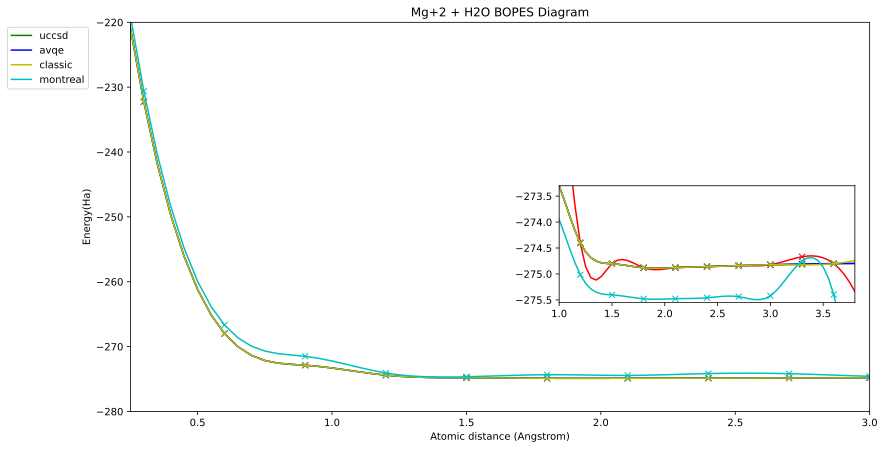

In [28]:
##QISKIT
distances = np.arange(0.3, 3.6, 0.3)
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
# ax.plot(distances,qiskit_engs['ryrz'],'rx')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax.plot(distances,qiskit_engs['uccsd'],'gx')
ax.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax.plot(distances,qiskit_engs['avqe'],'bx')
ax.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax.plot(distances,qiskit_engs['classic'],'yx')
ax.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax.plot(rdistances,real_engs['montreal'],'cx')
ax.plot(x, real_interp['montreal']['popt'](x), 'c-',label='montreal')

# ax.plot(distances,qiskit_engs['pyscf'],'cx')
# ax.plot(x, qiskit_interp['pyscf']['popt'](x), '-',label='pyscf')

# ax.plot(distances,pyscf_engs['HF'],'cx')
# ax.plot(x, pyscf_interp['HF']['popt'](x), '-',label='HF')

# # ax.plot(distances,pyscf_engs['DFT'],'cx')
# # ax.plot(x, pyscf_interp['DFT']['popt'](x), '-',label='DFT')

# ax.plot(distances,pyscf_engs['CI'],'cx')
# ax.plot(x, pyscf_interp['CI']['popt'](x), '-',label='CI')

ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins.plot(distances,qiskit_engs['ryrz'],'rx')
axins.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-')

axins.plot(distances,qiskit_engs['uccsd'],'gx')
axins.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-')

axins.plot(distances,qiskit_engs['avqe'],'bx')
axins.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

axins.plot(distances,qiskit_engs['classic'],'yx')
axins.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

axins.plot(distances,qiskit_engs['pyscf'],'cx')
axins.plot(x, qiskit_interp['pyscf']['popt'](x), 'c-')


xx1, xx2, yy1, yy2 = 1.0,3.8, -275.55, -273.3
axins.set_xlim(xx1, xx2)
axins.set_ylim(yy1, yy2)

x1, x2, y1, y2 = 0.25,3, -280, -220
ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

#ax.indicate_inset_zoom(axins, edgecolor="black")



Finally we export this data as .csv files

In [42]:
import csv

with open('MG+H2O/simulations/ryrz_energies', 'w') as f:
    write = csv.writer(f)

    write.writerow(qiskit_engs['ryrz'])
    write.writerow(distances)

In [33]:
len(qiskit_engs['ryrz'])

12

In [34]:
len(distances)

12

In [51]:
print(avqe_results[0])

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -422.232279765715
  - computed part:      -82.439546540076
  - ActiveSpaceTransformer extracted energy part: -339.792733225639
~ Nuclear repulsion energy (Hartree): 189.987230368755
> Total ground state energy (Hartree): -232.24504939696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 12.000 S: 0.013 S^2: 0.013 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.93591401]
 
  0: 
  * Electronic dipole moment (a.u.): [None  None  3.00880134]
    - computed part:      [None  None  0.00690717]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  3.00189416]
  > Dipole moment (a.u.): [None  None  0.92711267]  Total: None
                 (debye): [None  None  2.35648515]  Total: None
 


### Draft

In [73]:
!pip install quantum-serverless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.3 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:01:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━